# Image classification using VGG NET

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from keras.layers.normalization import BatchNormalization
import gc  # Gabage collector for cleaning deleted data from memory

#Import Keras functions
from keras import Sequential
from keras import backend as K
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dropout, Dense
from keras.models import Model
import keras
import matplotlib.pyplot as plt


train = pd.read_csv('training_labels.csv')

In [26]:
print("No of different labels in the csv")
train['label'].value_counts()

No of different labels in the csv


-1    347
 0    261
 1     20
Name: label, dtype: int64

In [12]:
#Convert images to numpy array and store it inside X and store labels in y
import cv2
trainImage = []
y = np.zeros(shape=(0,3))
for i in range (train.shape[0]):
    img = cv2.imread(''+train['Subject'].iloc[i]+'.png')
    if img is None:
        continue
    trainImage.append(img)
    if train['label'].iloc[i] == -1:
        newrow = [1,0,0]
    elif train['label'].iloc[i] == 0:
        newrow = [0,1,0]
    elif train['label'].iloc[i] == 1:
        newrow = [0,0,1]
        
    y = np.vstack((y, newrow))
    

In [13]:
X = np.array(trainImage) #Convert into numpy array

In [14]:
X = X/255 #Normalize the images
from sklearn.model_selection import train_test_split
#Split into train & test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

In [15]:

##Define the model
input_shape = (306, 426, 3)

class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1


        model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.45))

        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.45))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Dense(classes))
        model.add(Activation("sigmoid"))

        return model


model = SmallerVGGNet.build(width=426, height=306, depth=3, classes=3)


model.compile(loss = 'categorical_crossentropy', 
            optimizer = 'adam', metrics = ['acc'])

from keras.callbacks import ModelCheckpoint

early_stop = keras.callbacks.EarlyStopping(patience=50) 
checkpointer = ModelCheckpoint(filepath='mrimodel1.h5', verbose=1, save_best_only=True)
callbacks = [checkpointer,early_stop] 

In [16]:
model.fit(X_train, y_train, epochs=30,verbose=1, validation_data=(X_val, y_val), batch_size=32, callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 482 samples, validate on 121 samples
Epoch 1/30
482/482 [==============================] - 169s 352ms/step - loss: 1.2279 - acc: 0.3465 - val_loss: 1.0418 - val_acc: 0.3471

Epoch 00001: val_loss improved from inf to 1.04183, saving model to mrimodel1.h5
Epoch 2/30
482/482 [==============================] - 146s 302ms/step - loss: 0.9480 - acc: 0.4689 - val_loss: 0.9770 - val_acc: 0.4711

Epoch 00002: val_loss improved from 1.04183 to 0.97698, saving model to mrimodel1.h5
Epoch 3/30
482/482 [==============================] - 148s 307ms/step - loss: 0.8244 - acc: 0.5311 - val_loss: 1.0076 - val_acc: 0.3967

Epoch 00003: val_loss did not improve from 0.97698
Epoch 4/30
482/482 [==============================] - 150s 311ms/step - loss: 0.7268 - acc: 0.6162 - val_loss: 0.8753 - val_acc: 0.5372

Epoch 00004: val_loss improved from 0.97698 to 0.87527, saving model to mrimodel1.h5
Epoch 5/30
482/482 [==============================] - 17

In [17]:
from sklearn.metrics import accuracy_score
proba = model.predict(X_val/255)

In [18]:
output = np.argmax(proba, axis=1)
y_true = np.argmax(y_val, axis=1)

In [19]:
print("Accuracy:",accuracy_score(y_true, output))

Accuracy: 0.04132231404958678


#Class Activation Function mapping

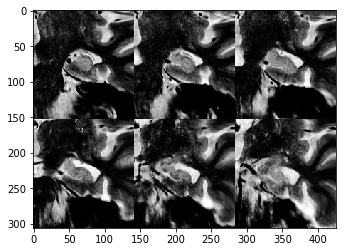

In [22]:
model2 = model
img_path = 'training/002_S_4654_20180522.png'
img=cv2.imread(img_path)
plt.imshow(img)
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(306,426))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
from keras.applications.vgg16 import preprocess_input
x = preprocess_input(x)
preds = model2.predict(x)
argmax = np.argmax(preds[0])
output = model2.output[:, argmax]

In [23]:
last_conv_layer = model2.layers[-12]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


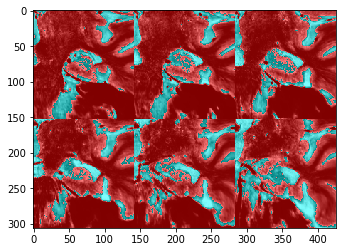

In [24]:
#last_conv_layer = model2.get_layer('block5_conv3') #======
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model2.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = 1
superimposed_img = heatmap * hif + img
plt.imshow(superimposed_img)
plt.show()

## Bonus Task - the code to apply the trained model on a new image

In [27]:
def predictOnNewImg(model2,img_path):
    global cv2
    img=cv2.imread(img_path)
    plt.imshow(img)
    plt.show()
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(306,426))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model2.predict(x)
    argmax = np.argmax(preds[0])
    output = model2.output[:, argmax]
    last_conv_layer = model2.layers[-12]
    #last_conv_layer = model2.get_layer('block5_conv3') #======
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model2.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = 1
    superimposed_img = heatmap * hif + img
    plt.imshow(superimposed_img)
    plt.show()

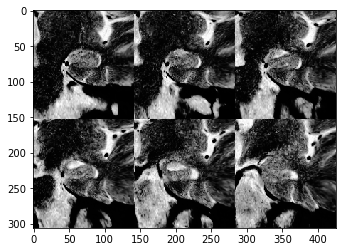

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


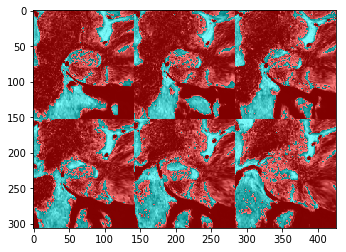

In [28]:
predictOnNewImg(model,'training/006_S_0731_20181010.png')